# California Wine Quality Project

## Goals: 
   * Explore the data with clustering models.
   * Develop a model that can accurately predict the quality level of the wine.

In [1]:
# Imports

#data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# data separation/transformation
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE # Recursive Feature Elimination¶

# modeling
from sklearn.cluster import KMeans
import sklearn.preprocessing

# statistics testing
import scipy.stats as stats

# system manipulation
from itertools import combinations
import os
import sys
sys.path.append("../util_")
import wrangle as w
import explore as e
#import prepare_
#import explore_

# other
import math
import env
import warnings
warnings.filterwarnings("ignore")

# set the random seed
np.random.seed(95)

## Acquire
 
 * Acquire data from Data.World
 * Original dataset combined from two separate dataframes into one
 * 6497 rows and 13 columns in final dataframe

## Prepare
* Rename columns
* No null values in the data
* Remove 1177 duplicated rows
* Create dummie varaibles (wine_clr)
* Split data into train, validate, and test. (60/20/20 split)
* Scale all columns except the target (quality) and the encoded (wine_clr)

In [2]:
train, validate, test = w.wrangle_wine_explore()

In [3]:
train_scaled, validate_scaled, test_scaled = w.wrangle_wine_model()

## Explore
* Use Recursive Feature Elimination to determine best features for wine quality

* Does the average quality score differ between red or white wines?

* Is there a relationship between volatile acidity and density?

    * What does clustering show us about this correlation?
    
* Is there a relationship between density and alcohol level?

* Is there a relationship between volatile acidity and free sulfur dioxide?

### Feature selection

In [4]:
x_feature_selected = e.feature_selection(train_scaled)
x_feature_selected.head()

,density_scaled,volatile_acidity_scaled,white,free_sulfur_dioxide_scaled,alcohol_scaled
0,0.225528,0.144,1,0.173010,0.478261
1,0.297111,0.248,1,0.186851,0.362319
2,0.391979,0.488,0,0.214533,0.275362
3,0.228116,0.168,1,0.062284,0.173913
4,0.223803,0.080,1,0.262976,0.405797


### Does the average quality score differ between red or white wines?

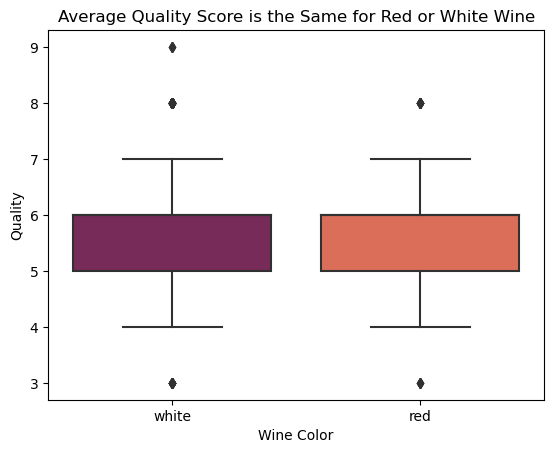

In [5]:
e.wine_color_quality_viz(train)

### Is there a relationship between volatile acidity and density?

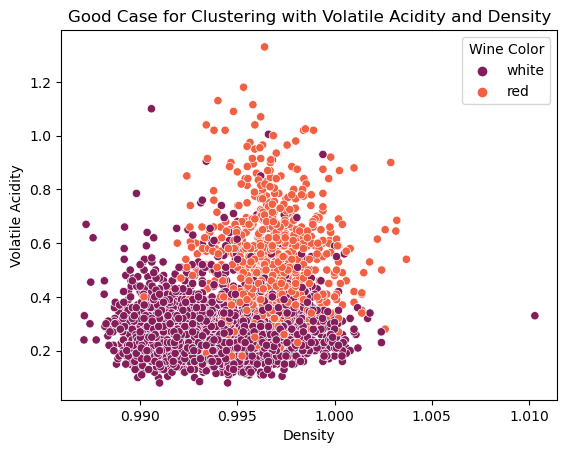

In [6]:
e.volatileacid_density_viz(train)

$H_0$: There is no linear correlation between density and volatile acidity.

$H_A$: There is a linear correlation between density and volatile acidity.

In [7]:
# run stats test
r, p = stats.pearsonr(train.density, train.volatile_acidity)
print(f'Correlation Coefficient: {r} , P-value: {p}')

Correlation Coefficient: 0.3175177891013551 , P-value: 1.0822214780616187e-75


We reject the null hypothesis.

### What clusters exist with density and volatile acidity?

In [8]:
feature_combinations, ceters, ceters2, model_df, model_df2 = e.volatile_cluster_model(x_feature_selected, train_scaled)

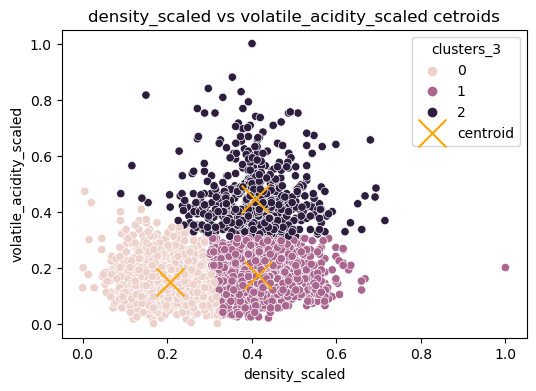

In [9]:
e.dense_vol_centroids(train_scaled, feature_combinations, ceters, model_df)

### Is there a relationship between density and alcohol levels?

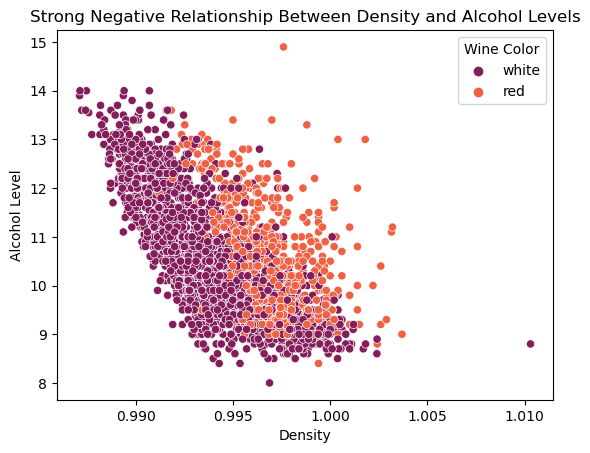

In [10]:
e.density_alcohol_viz(train)

$H_0$: There is no linear correlation between density and alcohol levels.

$H_A$: There is a linear correlation between density and alcohol levels.

In [11]:
# run stats test
r, p = stats.pearsonr(train.density, train.alcohol)
print(f'Correlation Coefficient: {r} , P-value: {p}')

Correlation Coefficient: -0.674453962839899 , P-value: 0.0


We reject the null hypothesis.

### What clusters exist with alcohol and density?

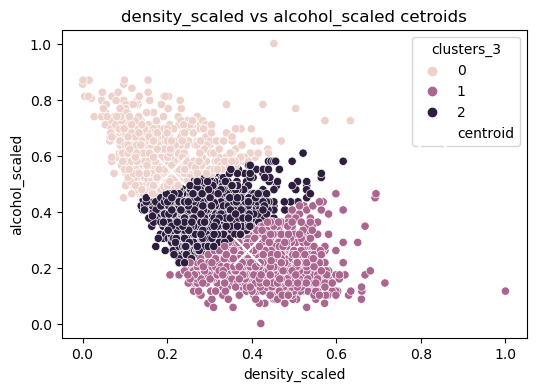

In [12]:
e.density_alc_clusters(train_scaled, feature_combinations, ceters2, model_df2)

### Is there a relationship between volatile acidity and free sulfur dioxides?

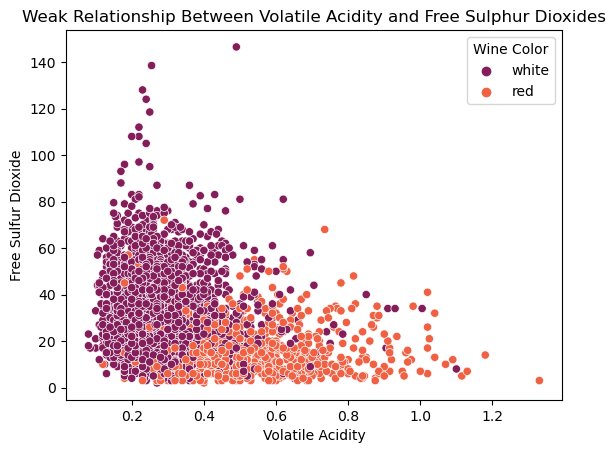

In [13]:
e.volatile_sulfur_viz(train)

$H_0$: There is no linear correlation between volatile acidity and free sulfur dioxides.

$H_A$: There is a linear correlation between volatile acidity and free sulfur dioxides.

In [14]:
# run stats test
r, p = stats.pearsonr(train.volatile_acidity, train.free_sulfur_dioxide)
print(f'Correlation Coefficient: {r} , P-value: {p}')

Correlation Coefficient: -0.34350171415811637 , P-value: 4.371451432392907e-89


We reject the null hypothesis.

## Explore Summary
* Important features selected by RFE: density, volatile acidity, free sulfur dioxides, alcohol and white wine.
* The average quality score is similar between red and white wines.
    * Due to this, and the disparate sample size between the two types, it was not included in the models.
* Volatile Acidity and Density are correlated and have a good case for clustering.
    * Clusters were binned into three categories for model:
        * Cluster 0: high density and low volatile acidity
        * Cluster 1: low density and low volatile acidity
        * Cluster 2: high density and high volatile acidity 
* There is a strong correlation between density and alcohol and were clustered.
    * Clusters were binned into three categories for model:
        * Cluster 0: high density and high alcohol
        * Cluster 1: high density and low alcohol
        * Cluster 2: mid density and mid alcohol
* There is a correlation between volatile acidity and free sulfur dioxides.

## Modeling
* Accuracy was used as an evaluation metric
* Target variable was binned to improve model performance.
    * Low Score Wine: Quality Score of 5 and Lower
    * High Score Wine: Quality Score of 6 and Higher

In [15]:
train_scaled, validate_scaled, test_scaled, xtrain, ytrain, xval, yval, xtest, ytest = e.modeling_prep(train_scaled, validate_scaled, test_scaled, feature_combinations, model_df, model_df2)

In [17]:
# get the baseline
train_scaled, baseline = e.model_baseline(train_scaled, ytrain)

### KNN

In [18]:
knn_model_df = e.knn_model(xtrain, ytrain, xval, yval, baseline)

# the best knn model
knn_model_df[knn_model_df.k == 5]

,k,train_score,validate_score,difference,train_baseline_diff,baseline_accuracy
4,5,0.813283,0.615602,0.197682,-0.187343,0.62594


### Decision Tree

In [19]:
decTree_model_df = e.decTree_model(xtrain, ytrain, xval, yval, baseline)

# the best decision tree model
decTree_model_df[decTree_model_df.depth == 3]

,depth,train_score,validate_score,difference,train_baseline_diff,baseline_accuracy
2,3,0.732769,0.734962,-0.002193,-0.10683,0.62594


### Random Forest

In [20]:
randFor_model_df = e.randFor_model(xtrain, ytrain, xval, yval, baseline)

# the best decision tree model
randFor_model_df[randFor_model_df.trees == 6]

,trees,train_score,validate_score,difference,train_baseline_diff,baseline_accuracy
4,6,0.779762,0.726504,0.053258,-0.153822,0.62594


### Logistic Regression

In [21]:
logReg_model_df = e.logReg_model(xtrain, ytrain, xval, yval, baseline)

# the best decision tree model
logReg_model_df[logReg_model_df.c == 0.0101]

,c,train_score,validate_score,difference,train_baseline_diff,baseline_accuracy
1,0.0101,0.704261,0.628759,0.075501,-0.078321,0.62594


### Final Best Model on Test Data - Decision Tree

In [22]:
decTree_model_df = e.test_decTree(xtrain, ytrain, xval, yval, xtest, ytest, baseline)

# final results
decTree_model_df.head()

,depth,train_score,validate_score,test_score,train_test_diff,test_baseline_diff,baseline_accuracy
0,3,0.732769,0.734962,0.718985,0.013784,-0.093045,0.62594


## Conclusion
* Decision Tree is the best performing model with approximately 72% accuracy on unseen data.
* However, this accuracy only applies to the broad categories of low quality wine (quality score of < = 5) and high quality wine (quality score of > = 6)

## Next Steps
* Develop a model that can predict a specific quality score.

## Recommendations
* If the current target groups of low vs high quality wine is sufficient, implement this model.
* Search for data that is from California wines because the location where the grapes and wine is produced may impact the physiochemical properties.
